# REDES NUERONALES RECURRENTES

Implementacion con un set de sañales trigonometricas.

## Funciones comunes a todas la partes

In [34]:
# Librerias
import numpy as np
import matplotlib.pyplot as plt 
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error

In [35]:
# Funcion para generar base de datos de señales
def generate_time_series(batch_size, n_steps, n_future):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps + n_future)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps + n_future) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [36]:
# función que plotea un array de curvas (inputs y outputs)
def plot_series(series, y=None, y_pred=None, y_pred_std=None, x_label="$t$", y_label="$x$"):
  r, c = 3, 5
  fig, axes = plt.subplots(nrows=r, ncols=c, sharey=True, sharex=True, figsize=(20, 10))
  for row in range(r):
    for col in range(c):
        plt.sca(axes[row][col])
        ix = col + row*c
        plt.plot(series[ix, :], ".-")
        if y is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y[ix])), y[ix], "bx", markersize=10)
        if y_pred is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix], "ro")
        if y_pred_std is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] + y_pred_std[ix])
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] - y_pred_std[ix])
        plt.grid(True)
        plt.hlines(0, 0, 100, linewidth=1)
        plt.axis([0, len(series[ix, :])+len(y[ix]), -1, 1])
        if x_label and row == r - 1:
          plt.xlabel(x_label, fontsize=16)
        if y_label and col == 0:
          plt.ylabel(y_label, fontsize=16, rotation=0)
  plt.show()



In [37]:
# Clase dataset para luego armar los dataloader
class TimeSeriesDataset(Dataset):
  def __init__(self, X, y=None, train=True):
    self.X = X
    self.y = y
    self.train = train

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    if self.train:
      return torch.from_numpy(self.X[ix]), torch.from_numpy(self.y[ix])
    return torch.from_numpy(self.X[ix]) # si no es train, solo devuelve el X


In [45]:
# funciones de entrenamiento

from tqdm import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, dataloader, epochs=10):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.MSELoss()

    for epoch in range(epochs+1):
        print("epoch numero: ", epoch)
        bar = tqdm(dataloader['train'])
        model.train()
        train_loss = []
        eval_loss = []
        for batch in bar:
            X, y = batch
            #print(X.shape)
            #input()
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)

            #print('y shape')
            #print(y.shape)
            y = y.view(y.shape[0], -1) # aca elimino la dim de la profundidad
            #print(y.shape)
            #print(' y hat shape')
            #print(y_hat.shape)
            
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            bar.set_description(f"train_loss {np.mean(train_loss):.5f}")
        
        bar = tqdm(dataloader['eval'])
        model.eval()
        
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                y = y.view(y.shape[0], -1)
                loss = criterion(y_hat, y)
                eval_loss.append(loss.item())
                bar.set_description(f"valid_loss {np.mean(eval_loss):.5f}")
        
def predict(model, dataloader):
    model.eval()
    with torch.no_grad():
        preds = torch.tensor([]).to(device)
        for batch in dataloader:
            X = batch
            X = X.to(device)
            pred = model(X)
            preds = torch.cat([preds, pred])
        return preds

In [39]:
# función para imprimir parametros del modelo.
def imp_param(model):
  print('-'*84)
  print('PARAMETROS DEL MODELO')
  print('-'*84)
  for name, param in model.named_parameters():
    if param.requires_grad: 
      print('Nombre del parámetro: ')
      print(name)
      print('Tamaño del parámetro: ')
      print(param.data.shape)
      print()

# predecimos 10 valores a futuro, colocando la última predicción en la entrada, hasta llegar a 10 pasos iterativos

series shape
(10000, 60, 1)
X and y Train shape
(7000, 50, 1) (7000, 10, 1)
X and y Valid shape
(2000, 50, 1) (2000, 10, 1)
X and y Test shape
(1000, 50, 1) (1000, 10, 1)


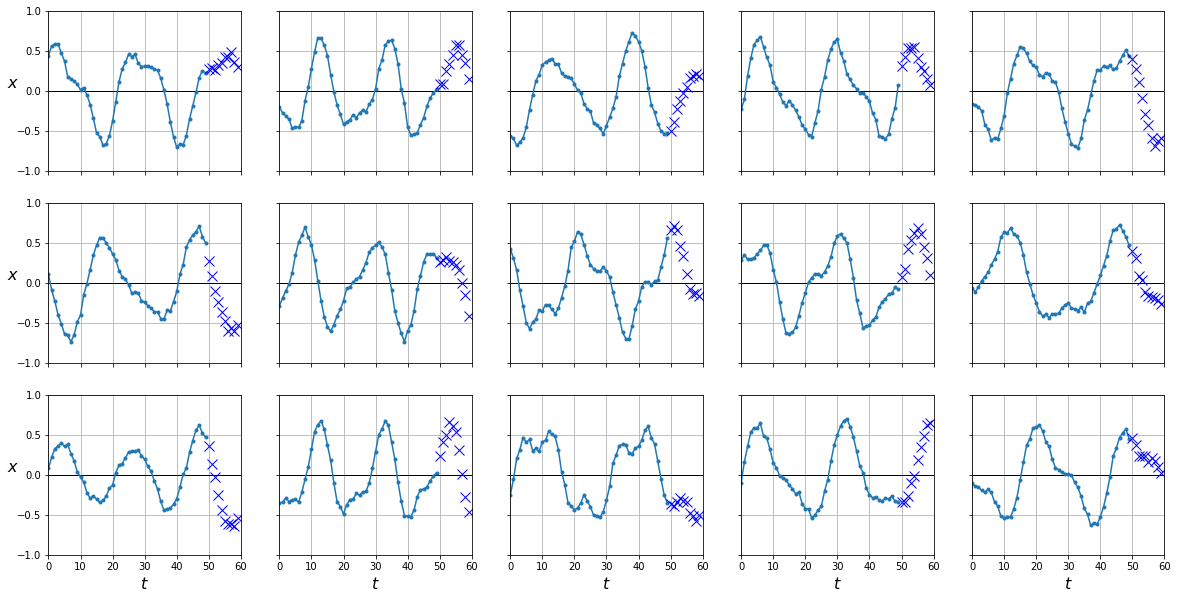

(1000, 10, 1)
(1000, 1, 1)


In [40]:
# generamos unos nuevos datos para tener con qué comparar

n_steps = 50
n_future = 10

series = generate_time_series(10000, n_steps, n_future)
print('series shape')
print(series.shape)

X_train, y_train = series[:7000, :n_steps], series[:7000, -n_future:]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -n_future:]
X_test, y_test = series[9000:, :n_steps], series[9000:, -n_future:]
print('X and y Train shape')
print(X_train.shape, y_train.shape)

print('X and y Valid shape')
print(X_valid.shape, y_valid.shape)

print('X and y Test shape')
print(X_test.shape, y_test.shape)

# ploteamos
plot_series(X_test, y_test)
print(y_test.shape)
print(y_test[:,:1,:].shape)

In [41]:
class MLP(torch.nn.Module):
  def __init__(self, n_in=n_steps, n_out=n_future):
    super().__init__()
    self.fc = torch.nn.Linear(n_in, n_out)

  def forward(self, x):
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x

# n_steps y out_future definidos arriba
mlp = MLP(n_steps, n_future)
mlp

MLP(
  (fc): Linear(in_features=50, out_features=10, bias=True)
)

In [ ]:
#  tenemos q armar un nuevo dataloader que pase 1 solo valor a futuro
# pero tengamos los siguientes 9 para ver el error de nuestra propia iteración
dataset = {
    'train': TimeSeriesDataset(X_train, y_train[:,:1,:]),
    'eval': TimeSeriesDataset(X_valid, y_valid[:,:1,:]),
    'test': TimeSeriesDataset(X_test, y_test[:,:1,:], train=False)
}

dataloader = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}
print(type(dataloader))


<class 'dict'>


In [ ]:
# veo primero una muestra del dataloader

xs, ys = next(iter(dataloader['train']))
print('tamaño del xs que le paso como input:')
print('batch x largo x nro features (si paso mas de 1 feature por tiempo)')
print(xs.shape)
print('---------')
print('tamaño del ys que le paso como output:')
print('batch x largo x nro features(si paso mas de 1 feature por tiempo)')
print(ys.shape)

tamaño del xs que le paso como input:
batch x largo x nro features (si paso mas de 1 feature por tiempo)
torch.Size([64, 50, 1])
---------
tamaño del ys que le paso como output:
batch x largo x nro features(si paso mas de 1 feature por tiempo)
torch.Size([64, 1, 1])


epoch numero:  0


valid_loss 0.00313: 100%|██████████| 32/32 [00:00<00:00, 349.06it/s]


epoch numero:  1


valid_loss 0.00312: 100%|██████████| 32/32 [00:00<00:00, 191.02it/s]


epoch numero:  2


valid_loss 0.00310: 100%|██████████| 32/32 [00:00<00:00, 181.49it/s]


epoch numero:  3


valid_loss 0.00306: 100%|██████████| 32/32 [00:00<00:00, 268.83it/s]


epoch numero:  4


valid_loss 0.00296: 100%|██████████| 32/32 [00:00<00:00, 233.64it/s]


epoch numero:  5


valid_loss 0.00292: 100%|██████████| 32/32 [00:00<00:00, 228.81it/s]


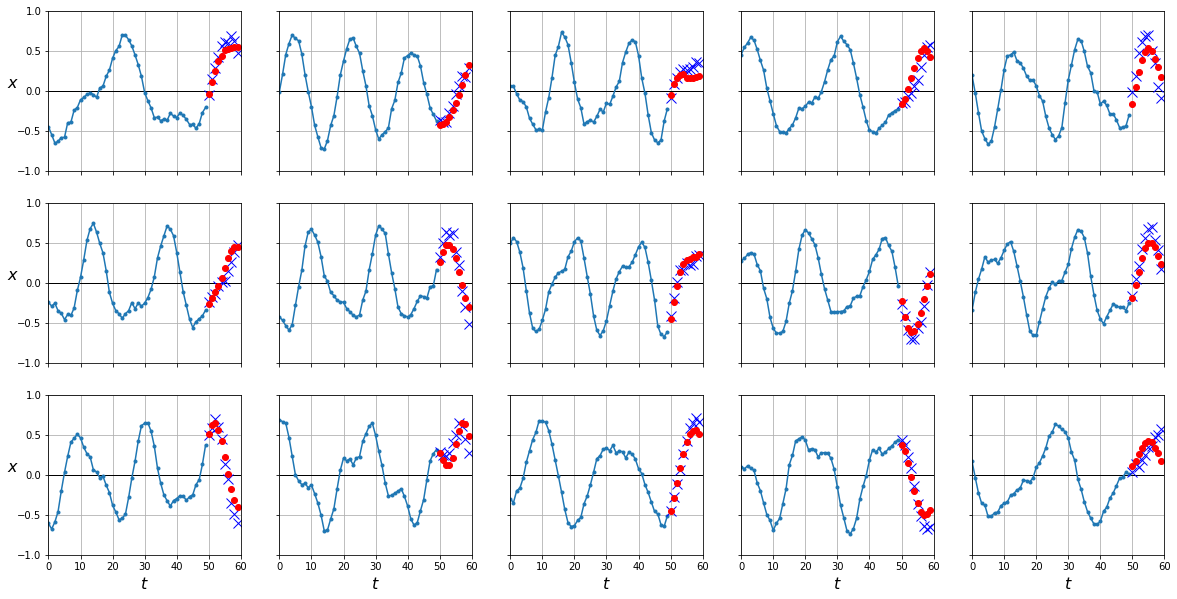

(1000, 10, 1)
(1000, 10)


0.016953364

In [ ]:
# lo comparamos en el mlp
# entreno de nuevo el mlp con los nuevos datos y graficamos

fit(mlp, dataloader)

X = X_test
for step_ahead in range(10):
    inputs = torch.from_numpy(X[:, step_ahead:]).unsqueeze(0)  # para el predict lea bien los datos (de este modo lee batch x largo x prof)
    y_pred_one = predict(mlp, inputs).cpu().numpy()
    X = np.concatenate([X, y_pred_one[:, np.newaxis, :]], axis=1)

y_pred = X[:, n_steps:, -1]
plot_series(X_test, y_test, y_pred)
print(y_test.shape)
print(y_pred.shape)
mean_squared_error(np.squeeze(y_test), y_pred)


## TP_5

##Crear una RNN que tenga 10 salidas y mejore el error del MLP usado antes. Asegurarse de compararlos con el mismo set datos!!

In [42]:
# Creamos un dataloader que nos cargue 10 valores a futuro
dataset_2 = {
    'train': TimeSeriesDataset(X_train, y_train),
    'eval': TimeSeriesDataset(X_valid, y_valid),
    'test': TimeSeriesDataset(X_test, y_test, train=False)
}

dataloader_2 = {
    'train': DataLoader(dataset_2['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset_2['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset_2['test'], shuffle=False, batch_size=64)
}
print(type(dataloader_2))

<class 'dict'>


In [46]:
class DeepRNN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size=1, hidden_size=25, num_layers=15 , batch_first=True)
    self.fc = torch.nn.Linear(25, 10)

  def forward(self, x):
    x, h = self.rnn(x) 
    x = self.fc(x[:,-1])
    return x

In [47]:
rnn_deep = DeepRNN()
fit(rnn_deep, dataloader_2)


epoch numero:  0


valid_loss 0.04439: 100%|██████████| 32/32 [00:00<00:00, 41.53it/s]


epoch numero:  1


valid_loss 0.02649: 100%|██████████| 32/32 [00:00<00:00, 41.17it/s]


epoch numero:  2


valid_loss 0.02136: 100%|██████████| 32/32 [00:00<00:00, 41.53it/s]


epoch numero:  3


valid_loss 0.01817: 100%|██████████| 32/32 [00:00<00:00, 41.44it/s]


epoch numero:  4


valid_loss 0.01483: 100%|██████████| 32/32 [00:00<00:00, 41.79it/s]


epoch numero:  5


valid_loss 0.01351: 100%|██████████| 32/32 [00:00<00:00, 41.92it/s]


epoch numero:  6


valid_loss 0.01333: 100%|██████████| 32/32 [00:00<00:00, 41.32it/s]


epoch numero:  7


valid_loss 0.00837: 100%|██████████| 32/32 [00:00<00:00, 41.69it/s]


epoch numero:  8


valid_loss 0.01014: 100%|██████████| 32/32 [00:00<00:00, 42.74it/s]


epoch numero:  9


valid_loss 0.00814: 100%|██████████| 32/32 [00:00<00:00, 42.13it/s]


epoch numero:  10


valid_loss 0.00701: 100%|██████████| 32/32 [00:00<00:00, 42.31it/s]


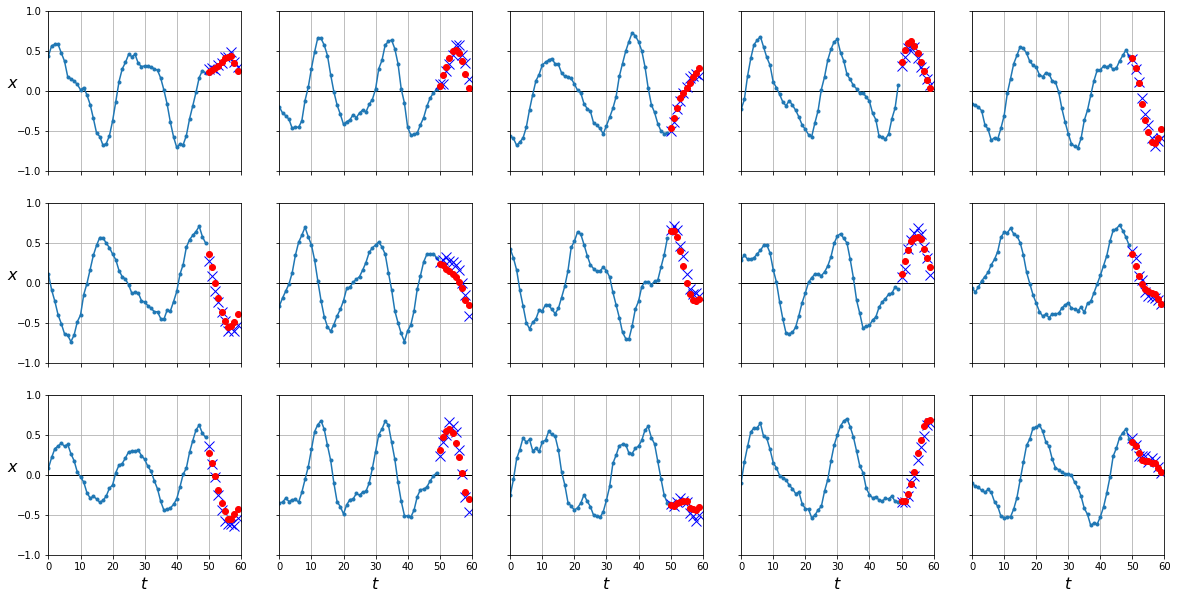

y_test shape:
(1000, 10, 1)
y_pred shape:
torch.Size([1000, 10])
Error cuadratico medio de la estimación final: 


0.0072032725

In [48]:
y_pred = predict(rnn_deep, dataloader_2['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())

y_testb = np.squeeze(y_test)
print('y_test shape:')
print(y_test.shape)
print('y_pred shape:')
print(y_pred.shape)
print('Error cuadratico medio de la estimación final: ')
mean_squared_error(np.squeeze(y_test), np.squeeze(y_pred))